# 2. Import libraries and read data

In [1]:
import joblib
import optuna
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna.visualization as vis


# 4. Modeling

## 4.1 Model preparation

### 4.1.1 Train-Test Split

In [2]:
from joblib import Parallel, delayed
from joblib import parallel_backend

In [3]:
df = pd.read_csv("data_resampled_30.csv")

### 4.1.3 Cross Vallidation

In [4]:
majority_class = df[df['Outcome'] == 0]
minority_class = df[df['Outcome'] == 1]

# Define the number of samples to select
n_samples = 50

# Perform random sampling
sampled_majority = majority_class.sample(n_samples, random_state=123)
sampled_minority = minority_class.sample(n_samples, random_state=123)

# Combine sampled data
sampled_df = pd.concat([sampled_majority, sampled_minority])
sampled_df

#test
y_test = sampled_df['Outcome']
x_test = sampled_df.drop(columns='Outcome')

# train
# Separate remaining data for training
remaining_df = df.drop(sampled_df.index)
y_train = remaining_df['Outcome']
x_train= remaining_df.drop(columns='Outcome')

scaler = StandardScaler()
scaler.fit(x_train)

x_train_ = scaler.transform(x_train)
x_test_ = scaler.transform(x_test)

In [5]:
#from sklearn.model_selection import RepeatedKFold
rs=123
cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=345)

## Basic Structure of an Optuna Optimization Script

The overall process works differently from the brute-force approach of GridSearchCV. Because of this, let's cover off the different components of the process:

1. Defining the objective function
2. Creating a Study Object
3. Running the Optimization Process

The objective function is at the core of how Optuna optimizes the hyperparameter selections. While a brute-force grid search also seeks to minimize an objective function, it doesn't actually take into account what combination of hyperparameters is doing well or not.

## 4.2 KNN (K-Nearest Neighbors Algorithm)

In [6]:
# Creating an Objective Function

def objective_knn(trial):
    
    # Define hyperparameters
    param_knn = {'n_neighbors' : trial.suggest_int('n_neighbors', 1, 100)
    ,'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan','minkowski']),
    'p' : trial.suggest_int('p', 1, 50),
    'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree', 'kd_tree', 'brute']),
    'leaf_size' : trial.suggest_int('leaf_size', 1, 100)}

    # Create and train the model
    knn = KNeighborsClassifier(**param_knn)
    knn.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(knn, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [7]:
# Creating and running our optimization
study_knn = optuna.create_study(direction='maximize',study_name = "KNN")
study_knn.optimize(objective_knn, n_trials=100)

[I 2024-08-26 01:24:39,374] A new study created in memory with name: KNN
[I 2024-08-26 01:24:39,790] Trial 0 finished with value: 0.7207955043034083 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'euclidean', 'p': 49, 'algorithm': 'auto', 'leaf_size': 45}. Best is trial 0 with value: 0.7207955043034083.
[I 2024-08-26 01:24:39,915] Trial 1 finished with value: 0.7534149806442327 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean', 'p': 30, 'algorithm': 'auto', 'leaf_size': 45}. Best is trial 1 with value: 0.7534149806442327.
[I 2024-08-26 01:24:40,583] Trial 2 finished with value: 0.6010120737155472 and parameters: {'n_neighbors': 41, 'weights': 'uniform', 'metric': 'minkowski', 'p': 22, 'algorithm': 'brute', 'leaf_size': 76}. Best is trial 1 with value: 0.7534149806442327.
[I 2024-08-26 01:24:41,107] Trial 3 finished with value: 0.5672292543637135 and parameters: {'n_neighbors': 76, 'weights': 'distance', 'metric': 'minkowski', 'p': 37,

[I 2024-08-26 01:24:49,902] Trial 32 finished with value: 0.8107859978205711 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan', 'p': 39, 'algorithm': 'auto', 'leaf_size': 26}. Best is trial 32 with value: 0.8107859978205711.
[I 2024-08-26 01:24:50,177] Trial 33 finished with value: 0.7739793389460372 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan', 'p': 43, 'algorithm': 'auto', 'leaf_size': 24}. Best is trial 32 with value: 0.8107859978205711.
[I 2024-08-26 01:24:50,433] Trial 34 finished with value: 0.77220335657248 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'manhattan', 'p': 38, 'algorithm': 'auto', 'leaf_size': 43}. Best is trial 32 with value: 0.8107859978205711.
[I 2024-08-26 01:24:50,681] Trial 35 finished with value: 0.744711382381255 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'manhattan', 'p': 48, 'algorithm': 'auto', 'leaf_size': 18}. Best is trial 32 with value: 0.8107

[I 2024-08-26 01:24:59,483] Trial 65 finished with value: 0.7419791639581603 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'manhattan', 'p': 44, 'algorithm': 'ball_tree', 'leaf_size': 5}. Best is trial 32 with value: 0.8107859978205711.
[I 2024-08-26 01:24:59,903] Trial 66 finished with value: 0.7718727690745735 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'manhattan', 'p': 42, 'algorithm': 'ball_tree', 'leaf_size': 18}. Best is trial 32 with value: 0.8107859978205711.
[I 2024-08-26 01:25:00,151] Trial 67 finished with value: 0.7730463384566291 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'manhattan', 'p': 46, 'algorithm': 'ball_tree', 'leaf_size': 11}. Best is trial 32 with value: 0.8107859978205711.
[I 2024-08-26 01:25:00,835] Trial 68 finished with value: 0.6220048615944498 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'minkowski', 'p': 7, 'algorithm': 'kd_tree', 'leaf_size': 24}. Best is trial 3

[I 2024-08-26 01:25:09,042] Trial 97 finished with value: 0.7945656988135287 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan', 'p': 43, 'algorithm': 'auto', 'leaf_size': 10}. Best is trial 32 with value: 0.8107859978205711.
[I 2024-08-26 01:25:09,305] Trial 98 finished with value: 0.7566063941753761 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'manhattan', 'p': 41, 'algorithm': 'ball_tree', 'leaf_size': 1}. Best is trial 32 with value: 0.8107859978205711.
[I 2024-08-26 01:25:09,492] Trial 99 finished with value: 0.780910194611517 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'p': 47, 'algorithm': 'auto', 'leaf_size': 25}. Best is trial 32 with value: 0.8107859978205711.


In [8]:
# Evaluating our Optuna Trial
print("Best trial:", study_knn.best_trial.number)
print("Best accuracy:", study_knn.best_trial.value)
print("Best hyperparameters:", study_knn.best_params)

Best trial: 32
Best accuracy: 0.8107859978205711
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan', 'p': 39, 'algorithm': 'auto', 'leaf_size': 26}


              precision    recall  f1-score   support

           0     0.7705    0.9400    0.8468        50
           1     0.9231    0.7200    0.8090        50

    accuracy                         0.8300       100
   macro avg     0.8468    0.8300    0.8279       100
weighted avg     0.8468    0.8300    0.8279       100



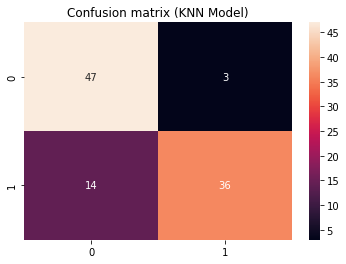

In [36]:
best_param_knn = study_knn.best_params
KNN = KNeighborsClassifier(**best_param_knn).fit(x_train_,y_train)
y_pred_knn = KNN.predict(x_test_)

def display_results(y_test, y_pred, cm_title):
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
    print(classification_report(y_test,y_pred, digits=4))
    
display_results(y_test, y_pred_knn, cm_title = "Confusion matrix (KNN Model)")

Accuracy: 0.8300
Precision: 0.9231
Recall: 0.7200
F1 Score: 0.8090

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



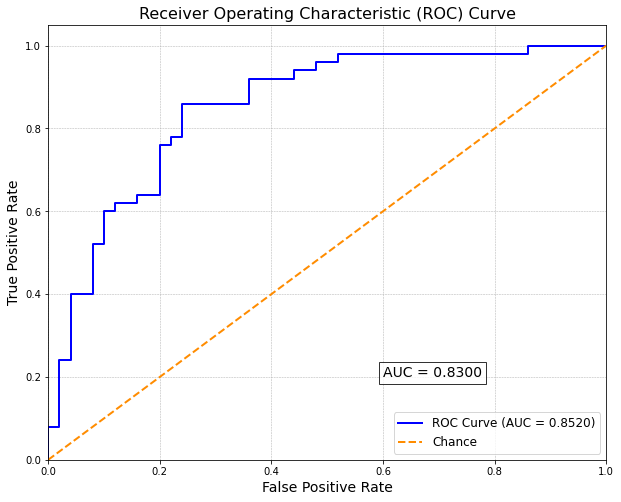

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, classification_report

# Get the best parameters from the Optuna study and train the KNN model
best_knn = KNeighborsClassifier(**study_knn.best_params)
best_knn.fit(x_train_, y_train)

# Predict on the test set
y_pred = best_knn.predict(x_test_)
y_proba = best_knn.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot the ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_knn:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()


## 4.3 Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def objective_lr(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }

    # Define hyperparameters
    param_logr = {
        'C': trial.suggest_float("C", 0.001, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
        'max_iter': trial.suggest_int("max_iter", 50, 1000),
        'class_weight': class_weight  # Apply custom class weights
    }

    # Create and train the model
    lr = LogisticRegression(**param_logr, random_state=42)
    
    # Evaluate the model using cross-validation with the f1_macro score to handle imbalance
    score = cross_val_score(lr, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score



In [12]:
# Creating and running our optimization

study_lr = optuna.create_study(direction='maximize',study_name = "logr")
study_lr.optimize(objective_lr, n_trials=100)

[I 2024-08-26 01:25:09,780] A new study created in memory with name: logr
[I 2024-08-26 01:25:10,131] Trial 0 finished with value: 0.6306516539614846 and parameters: {'C': 0.19734112562165623, 'solver': 'sag', 'max_iter': 60}. Best is trial 0 with value: 0.6306516539614846.
[I 2024-08-26 01:25:12,492] Trial 1 finished with value: 0.6539299901293011 and parameters: {'C': 0.23117582210030582, 'solver': 'sag', 'max_iter': 598}. Best is trial 1 with value: 0.6539299901293011.
[I 2024-08-26 01:25:13,078] Trial 2 finished with value: 0.6325809411308613 and parameters: {'C': 3.241508693896613, 'solver': 'sag', 'max_iter': 127}. Best is trial 1 with value: 0.6539299901293011.
[I 2024-08-26 01:25:17,509] Trial 3 finished with value: 0.7433197232012791 and parameters: {'C': 0.4131945927832681, 'solver': 'newton-cg', 'max_iter': 896}. Best is trial 3 with value: 0.7433197232012791.
[I 2024-08-26 01:25:21,596] Trial 4 finished with value: 0.7425739657883699 and parameters: {'C': 0.0915197452758566

[I 2024-08-26 01:26:55,715] Trial 40 finished with value: 0.6449714783781287 and parameters: {'C': 0.001013238305762767, 'solver': 'sag', 'max_iter': 558}. Best is trial 30 with value: 0.745186444559314.
[I 2024-08-26 01:26:58,439] Trial 41 finished with value: 0.7448559669995484 and parameters: {'C': 0.18138357098414426, 'solver': 'lbfgs', 'max_iter': 612}. Best is trial 30 with value: 0.745186444559314.
[I 2024-08-26 01:27:01,132] Trial 42 finished with value: 0.7444659566196006 and parameters: {'C': 0.24073125921270044, 'solver': 'lbfgs', 'max_iter': 666}. Best is trial 30 with value: 0.745186444559314.
[I 2024-08-26 01:27:03,808] Trial 43 finished with value: 0.7420092023691426 and parameters: {'C': 1.0374687828754283, 'solver': 'lbfgs', 'max_iter': 707}. Best is trial 30 with value: 0.745186444559314.
[I 2024-08-26 01:27:05,201] Trial 44 finished with value: 0.6427635739998838 and parameters: {'C': 0.10020680461860434, 'solver': 'sag', 'max_iter': 350}. Best is trial 30 with value

[I 2024-08-26 01:28:34,859] Trial 81 finished with value: 0.7450470654707607 and parameters: {'C': 0.20772295076020383, 'solver': 'lbfgs', 'max_iter': 753}. Best is trial 30 with value: 0.745186444559314.
[I 2024-08-26 01:28:37,557] Trial 82 finished with value: 0.7437920589844268 and parameters: {'C': 0.30467685521999294, 'solver': 'lbfgs', 'max_iter': 825}. Best is trial 30 with value: 0.745186444559314.
[I 2024-08-26 01:28:40,375] Trial 83 finished with value: 0.745186444559314 and parameters: {'C': 0.22185258166209865, 'solver': 'lbfgs', 'max_iter': 666}. Best is trial 30 with value: 0.745186444559314.
[I 2024-08-26 01:28:43,222] Trial 84 finished with value: 0.7425411683645308 and parameters: {'C': 0.5807886938472829, 'solver': 'lbfgs', 'max_iter': 690}. Best is trial 30 with value: 0.745186444559314.
[I 2024-08-26 01:28:45,860] Trial 85 finished with value: 0.7436306461337128 and parameters: {'C': 0.11233973301299457, 'solver': 'lbfgs', 'max_iter': 641}. Best is trial 30 with val

In [13]:
# Evaluating our Optuna Trial
print("Best trial:", study_lr.best_trial.number)
print("Best accuracy:", study_lr.best_trial.value)
print("Best hyperparameters:", study_lr.best_params)

Best trial: 30
Best accuracy: 0.745186444559314
Best hyperparameters: {'C': 0.21858583033617213, 'solver': 'lbfgs', 'max_iter': 688}


              precision    recall  f1-score   support

           0       0.62      0.96      0.75        50
           1       0.91      0.40      0.56        50

    accuracy                           0.68       100
   macro avg       0.76      0.68      0.65       100
weighted avg       0.76      0.68      0.65       100



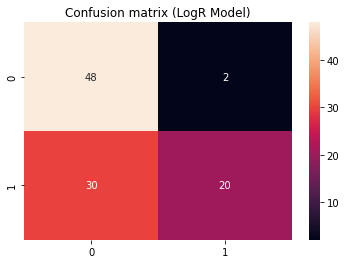

In [14]:
best_param_logr = study_lr.best_params
LR = LogisticRegression(**best_param_logr).fit(x_train_,y_train)
y_pred_lr = LR.predict(x_test_)
    
display_results(y_test, y_pred_lr, cm_title = "Confusion matrix (LogR Model)")

Accuracy: 0.6800
Precision: 0.9091
Recall: 0.4000
F1 Score: 0.5556

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.96      0.75        50
           1       0.91      0.40      0.56        50

    accuracy                           0.68       100
   macro avg       0.76      0.68      0.65       100
weighted avg       0.76      0.68      0.65       100



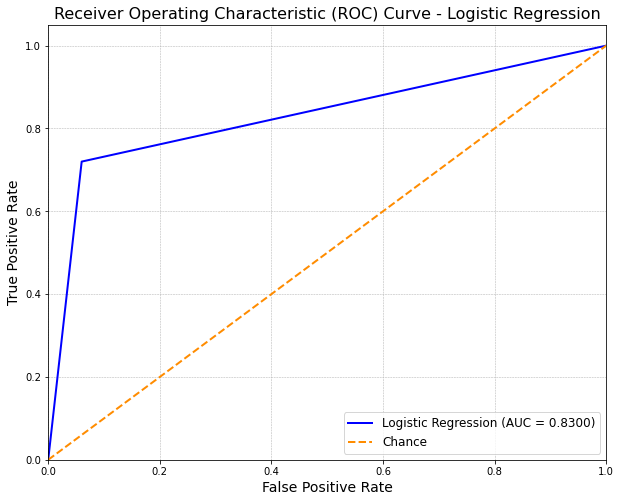

In [47]:
# Predict on the test set
y_pred_lr = LR.predict(x_test_)
y_proba_lr = LR.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Plot the ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_knn:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)


# Show the plot
plt.show()

## 4.4 Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective_dect(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_dect = {
        'max_depth' : trial.suggest_int("max_depth", 2, 64),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0.001, 10.0, log=True),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 30),
        'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 30),
        'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'class_weight': class_weight
    }

    # Create and train the model
    dect = DecisionTreeClassifier(**param_dect, random_state=123)
    dect.fit(x_train, y_train)

    # Evaluate the model
    score = cross_val_score(dect, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [17]:
# Creating and running our optimization
study_dect = optuna.create_study(direction='maximize',study_name = "Dect")
study_dect.optimize(objective_dect, n_trials=100)

[I 2024-08-26 01:29:10,549] A new study created in memory with name: Dect
[I 2024-08-26 01:29:10,704] Trial 0 finished with value: 0.7322191283652093 and parameters: {'max_depth': 61, 'ccp_alpha': 0.029792127365258558, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7322191283652093.
[I 2024-08-26 01:29:10,852] Trial 1 finished with value: 0.7759274351817383 and parameters: {'max_depth': 29, 'ccp_alpha': 0.013489925768948162, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7759274351817383.
[I 2024-08-26 01:29:10,994] Trial 2 finished with value: 0.2951047849865605 and parameters: {'max_depth': 38, 'ccp_alpha': 1.0257534828001533, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7759274351817383.
[I 2024-08-26 01:29:11,128] Trial 3 finished with value:

[I 2024-08-26 01:29:15,223] Trial 29 finished with value: 0.7912905109603534 and parameters: {'max_depth': 40, 'ccp_alpha': 0.0021122400369700456, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 26 with value: 0.7958396866383026.
[I 2024-08-26 01:29:15,378] Trial 30 finished with value: 0.809292565070369 and parameters: {'max_depth': 38, 'ccp_alpha': 0.0073318572180720585, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 30 with value: 0.809292565070369.
[I 2024-08-26 01:29:15,532] Trial 31 finished with value: 0.8105128386497826 and parameters: {'max_depth': 38, 'ccp_alpha': 0.005573296210675091, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 31 with value: 0.8105128386497826.
[I 2024-08-26 01:29:15,685] Trial 32 finished with value: 0.8084391371386305 and parameters: {'max_depth': 32, 'ccp_alpha': 0.0073

[I 2024-08-26 01:29:19,719] Trial 58 finished with value: 0.7818387511508834 and parameters: {'max_depth': 28, 'ccp_alpha': 0.01016724434030924, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 31 with value: 0.8105128386497826.
[I 2024-08-26 01:29:19,875] Trial 59 finished with value: 0.7270585406819382 and parameters: {'max_depth': 46, 'ccp_alpha': 0.019411689709497686, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 31 with value: 0.8105128386497826.
[I 2024-08-26 01:29:20,027] Trial 60 finished with value: 0.7601578609047813 and parameters: {'max_depth': 41, 'ccp_alpha': 0.0032212245695423, 'max_features': 'auto', 'min_samples_split': 30, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 31 with value: 0.8105128386497826.
[I 2024-08-26 01:29:20,181] Trial 61 finished with value: 0.8024212922296509 and parameters: {'max_depth': 31, 'ccp_alpha': 0.0071

[I 2024-08-26 01:29:24,269] Trial 87 finished with value: 0.8041115259359204 and parameters: {'max_depth': 25, 'ccp_alpha': 0.007899123894069058, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 31 with value: 0.8105128386497826.
[I 2024-08-26 01:29:24,438] Trial 88 finished with value: 0.7884009726871501 and parameters: {'max_depth': 21, 'ccp_alpha': 0.0019022112938786309, 'max_features': 'log2', 'min_samples_split': 27, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 31 with value: 0.8105128386497826.
[I 2024-08-26 01:29:24,592] Trial 89 finished with value: 0.7559585404931032 and parameters: {'max_depth': 23, 'ccp_alpha': 0.0024382784396501404, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 31 with value: 0.8105128386497826.
[I 2024-08-26 01:29:24,761] Trial 90 finished with value: 0.7645232142918335 and parameters: {'max_depth': 35, 'ccp_alpha': 0.00

In [18]:
# Evaluating our Optuna Trial
print("Best trial:", study_dect.best_trial.number)
print("Best accuracy:", study_dect.best_trial.value)
print("Best hyperparameters:", study_dect.best_params)

Best trial: 99
Best accuracy: 0.8106165288408492
Best hyperparameters: {'max_depth': 38, 'ccp_alpha': 0.007040730675103152, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 15, 'criterion': 'gini'}


              precision    recall  f1-score   support

           0       0.75      0.96      0.84        50
           1       0.94      0.68      0.79        50

    accuracy                           0.82       100
   macro avg       0.85      0.82      0.82       100
weighted avg       0.85      0.82      0.82       100



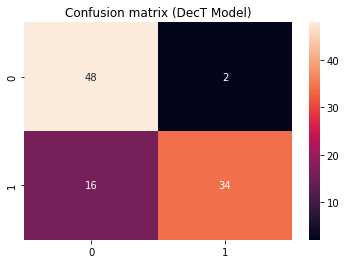

In [19]:
best_param_dect = study_dect.best_params
DecT = DecisionTreeClassifier(**best_param_dect,random_state=42).fit(x_train,y_train)
y_pred_dect = DecT.predict(x_test)
    

display_results(y_test, y_pred_dect, cm_title = "Confusion matrix (DecT Model)")

Accuracy: 0.7800
Precision: 1.0000
Recall: 0.5600
F1 Score: 0.7179

Classification Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.82        50
           1       1.00      0.56      0.72        50

    accuracy                           0.78       100
   macro avg       0.85      0.78      0.77       100
weighted avg       0.85      0.78      0.77       100



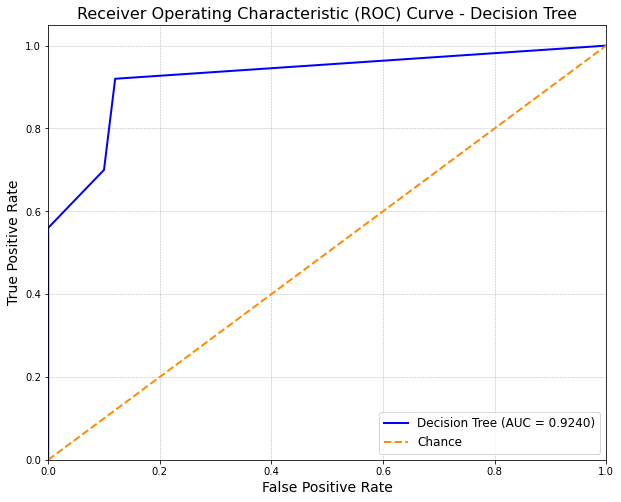

In [20]:
# Train the best Decision Tree model
best_param_dect = study_dect.best_params
best_dect = DecisionTreeClassifier(**best_param_dect, random_state=123)
best_dect.fit(x_train_, y_train)

# Predict on the test set
y_pred_dect = best_dect.predict(x_test_)
y_proba_dect = best_dect.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_dect = accuracy_score(y_test, y_pred_dect)
precision_dect = precision_score(y_test, y_pred_dect)
recall_dect = recall_score(y_test, y_pred_dect)
f1_dect = f1_score(y_test, y_pred_dect)

print(f"Accuracy: {accuracy_dect:.4f}")
print(f"Precision: {precision_dect:.4f}")
print(f"Recall: {recall_dect:.4f}")
print(f"F1 Score: {f1_dect:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dect))

# Plot the ROC curve
fpr_dect, tpr_dect, _ = roc_curve(y_test, y_proba_dect)
roc_auc_dect = auc(fpr_dect, tpr_dect)

plt.figure(figsize=(10, 8))
plt.plot(fpr_dect, tpr_dect, color='blue', lw=2, label=f'Decision Tree (AUC = {roc_auc_dect:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)


# Show the plot
plt.show()

## 4.5 SVM (Support Vector Machine)

In [21]:
# Creating an Objective Function

def objective_svm(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
                'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0),
                'class_weight': class_weight
                }

    # Create and train the model
    svm = SVC(**param_svm,random_state=rs)
    svm.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(svm, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [22]:
# Creating and running our optimization

study_svm = optuna.create_study(direction='maximize',study_name ="SVM")
study_svm.optimize(objective_svm, n_trials=100)

[I 2024-08-26 01:29:26,426] A new study created in memory with name: SVM
[I 2024-08-26 01:29:28,386] Trial 0 finished with value: 0.7968106932009746 and parameters: {'C': 64.72240802857601, 'gamma': 0.02065899408959619}. Best is trial 0 with value: 0.7968106932009746.
[I 2024-08-26 01:29:31,129] Trial 1 finished with value: 0.2951047849865605 and parameters: {'C': 0.007048435132159421, 'gamma': 7.07671268834858e-05}. Best is trial 0 with value: 0.7968106932009746.
[I 2024-08-26 01:29:32,698] Trial 2 finished with value: 0.7659336193471887 and parameters: {'C': 3.855553295255812, 'gamma': 0.00359989275892534}. Best is trial 0 with value: 0.7968106932009746.
[I 2024-08-26 01:29:34,304] Trial 3 finished with value: 0.780556735848376 and parameters: {'C': 203.72440175981086, 'gamma': 0.1142807241866505}. Best is trial 0 with value: 0.7968106932009746.
[I 2024-08-26 01:29:35,627] Trial 4 finished with value: 0.8083914586578622 and parameters: {'C': 6.116386640343423, 'gamma': 0.256620707178

[I 2024-08-26 01:30:44,564] Trial 41 finished with value: 0.8042929085249153 and parameters: {'C': 11.286213755149891, 'gamma': 0.4013551581735687}. Best is trial 17 with value: 0.8182528850159544.
[I 2024-08-26 01:30:46,167] Trial 42 finished with value: 0.8000970942295313 and parameters: {'C': 2.420994806370301, 'gamma': 0.45362776224542106}. Best is trial 17 with value: 0.8182528850159544.
[I 2024-08-26 01:30:47,588] Trial 43 finished with value: 0.8055510265812907 and parameters: {'C': 7.083855023057429, 'gamma': 0.20202241780448904}. Best is trial 17 with value: 0.8182528850159544.
[I 2024-08-26 01:30:48,883] Trial 44 finished with value: 0.797475337514691 and parameters: {'C': 4.015780801028543, 'gamma': 0.10818493022623671}. Best is trial 17 with value: 0.8182528850159544.
[I 2024-08-26 01:30:50,727] Trial 45 finished with value: 0.8135376606594582 and parameters: {'C': 0.33878017290235396, 'gamma': 0.5060921446937398}. Best is trial 17 with value: 0.8182528850159544.
[I 2024-08

[I 2024-08-26 01:31:57,435] Trial 83 finished with value: 0.8071105535541401 and parameters: {'C': 6.963776811506556, 'gamma': 0.40123356957842266}. Best is trial 17 with value: 0.8182528850159544.
[I 2024-08-26 01:31:58,810] Trial 84 finished with value: 0.8123531106896367 and parameters: {'C': 3.5727879315509017, 'gamma': 0.28883245731916024}. Best is trial 17 with value: 0.8182528850159544.
[I 2024-08-26 01:32:00,385] Trial 85 finished with value: 0.7735154795800722 and parameters: {'C': 10.01905373094638, 'gamma': 0.005070107683224613}. Best is trial 17 with value: 0.8182528850159544.
[I 2024-08-26 01:32:01,714] Trial 86 finished with value: 0.8094954619763121 and parameters: {'C': 4.175919422064078, 'gamma': 0.24377246790971926}. Best is trial 17 with value: 0.8182528850159544.
[I 2024-08-26 01:32:03,121] Trial 87 finished with value: 0.8059935607480756 and parameters: {'C': 3.468453216025874, 'gamma': 0.3257722411630256}. Best is trial 17 with value: 0.8182528850159544.
[I 2024-0

In [23]:
# Evaluating our Optuna Trial
print("Best trial:", study_svm.best_trial.number)
print("Best accuracy:", study_svm.best_trial.value)
print("Best hyperparameters:", study_svm.best_params)

Best trial: 17
Best accuracy: 0.8182528850159544
Best hyperparameters: {'C': 0.734755659799058, 'gamma': 0.393904011471575}


              precision    recall  f1-score   support

           0       0.74      0.96      0.83        50
           1       0.94      0.66      0.78        50

    accuracy                           0.81       100
   macro avg       0.84      0.81      0.81       100
weighted avg       0.84      0.81      0.81       100



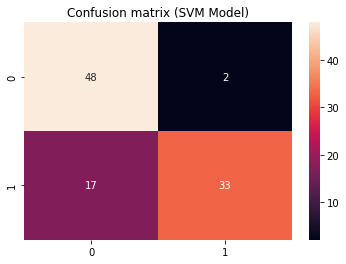

In [24]:
best_param_svm = study_svm.best_params
SVM = SVC(**best_param_svm,random_state=rs).fit(x_train_,y_train)
y_pred_svm = SVM.predict(x_test_)

display_results(y_test, y_pred_svm, cm_title = "Confusion matrix (SVM Model)")

Accuracy: 0.8100
Precision: 0.9429
Recall: 0.6600
F1 Score: 0.7765

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.83        50
           1       0.94      0.66      0.78        50

    accuracy                           0.81       100
   macro avg       0.84      0.81      0.81       100
weighted avg       0.84      0.81      0.81       100



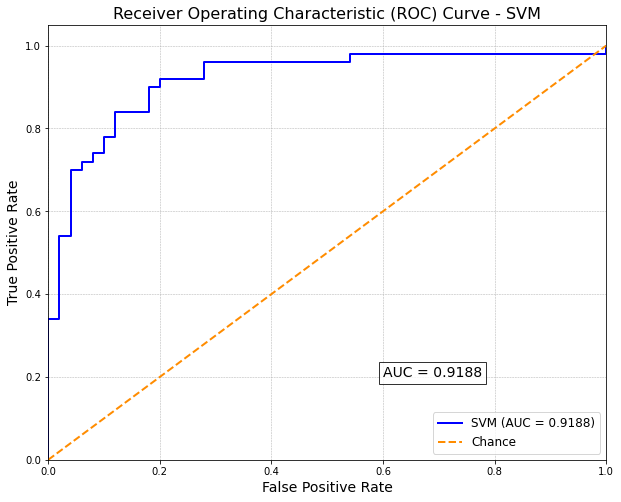

In [25]:
# Train the best SVM model
best_param_svm = study_svm.best_params
best_svm = SVC(**best_param_svm, random_state=123, probability=True)
best_svm.fit(x_train_, y_train)

# Predict on the test set
y_pred_svm = best_svm.predict(x_test_)
y_proba_svm = best_svm.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Plot the ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_svm:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()

## Xgboost

In [26]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score

def objective_xgb(trial: optuna.Trial):
    # Assume the data is already split into x_train_ and y_train_
    n_minority = y_train.sum()  # Number of minority class instances (assume minority class is '1')
    n_majority = len(y_train) - n_minority  # Number of majority class instances (assume majority class is '0')
    
    # Calculate scale_pos_weight
    scale_pos_weight = n_majority / n_minority
    
    # Define hyperparameters
    param_xgb = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': 0.1,  # Fixed at 0.1 as per your instructions
        'n_estimators': 200,  # Fixed at 200
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e1),
        'scale_pos_weight': scale_pos_weight  # Calculated to handle class imbalance
    }

    # Create and evaluate the XGBoost model
    xgb_model = xgb.XGBClassifier(**param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
    score = cross_val_score(xgb_model, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

# Example usage:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective_xgb, n_trials=100)


In [27]:
pos_weight = y_train.sum() / (len(y_train) - y_train.sum())
pos_weight

0.24808184143222506

In [28]:
# Creating and running our optimization
study_xgb = optuna.create_study(direction='maximize', study_name="XGBoost")

with parallel_backend('threading'):
    study_xgb.optimize(objective_xgb, n_trials=20, n_jobs=-1)

[I 2024-08-26 01:32:24,762] A new study created in memory with name: XGBoost
[I 2024-08-26 01:34:52,788] Trial 2 finished with value: 0.8638887580047805 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7493934945955305, 'colsample_bytree': 0.5243768160794959, 'reg_alpha': 3.243748521875789, 'reg_lambda': 1.964330879728704}. Best is trial 2 with value: 0.8638887580047805.
[I 2024-08-26 01:34:54,554] Trial 0 finished with value: 0.8687776575525217 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7952431794682191, 'colsample_bytree': 0.6400711788475875, 'reg_alpha': 1.496324812464736, 'reg_lambda': 2.5218121845316177}. Best is trial 0 with value: 0.8687776575525217.
[I 2024-08-26 01:34:58,007] Trial 7 finished with value: 0.8612870145425141 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.6918901600476317, 'colsample_bytree': 0.9953196994393629, 'reg_alpha': 0.025342671966948595, 'reg_lambda': 2.4945530250719075}. Best is 

In [29]:
# Evaluating our Optuna Trial
print("Best trial:", study_xgb.best_trial.number)
print("Best accuracy:", study_xgb.best_trial.value)
print("Best hyperparameters:", study_xgb.best_params)


Best trial: 11
Best accuracy: 0.8872979318553915
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.986827782686376, 'colsample_bytree': 0.5386724987259568, 'reg_alpha': 0.001112450139633332, 'reg_lambda': 0.15337435437333252}


              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100



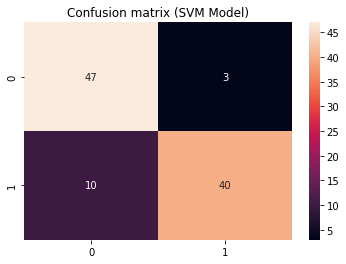

In [35]:
# Train the best XGBoost model
best_param_xgb = study_xgb.best_params
best_xgb = xgb.XGBClassifier(**best_param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
best_xgb.fit(x_train_, y_train)
xgb=best_xgb.fit(x_train_, y_train)
y_pred_xgb = xgb.predict(x_test_)

display_results(y_test, y_pred_xgb, cm_title = "Confusion matrix (SVM Model)")

Accuracy: 0.8700
Precision: 0.9302
Recall: 0.8000
F1 Score: 0.8602

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100



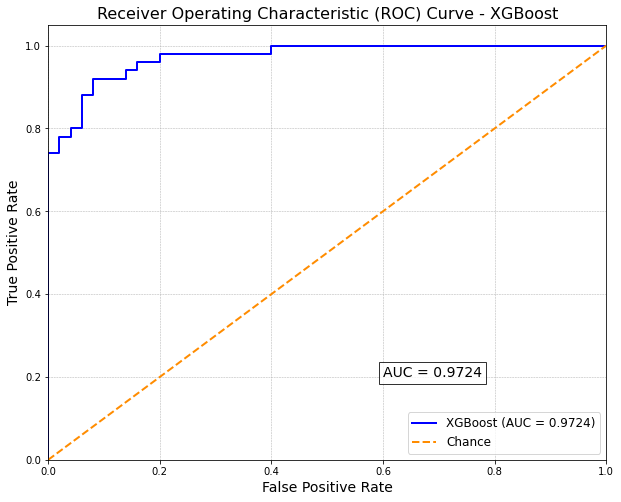

In [31]:
# Predict on the test set
y_pred_xgb = best_xgb.predict(x_test_)
y_proba_xgb = best_xgb.predict_proba(x_test_)[:, 1]

# Calculate and print metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Plot the ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Annotate AUC directly on the plot
plt.text(0.6, 0.2, f'AUC = {roc_auc_xgb:.4f}', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.show()

# 5. Models Comparison

The ROC-Curve plot provides us with a clear view to choose the best model, as it is evident that the decision tree model has the largest area under the curve. Therefore, based on the ROC , the decision tree model is selected as the best model.

In [48]:


# Create a dictionary to store the metrics for each model
metrics_summary = {
    "Model": ["KNN", "SVM", "LR", "DecT", "XGB"],
    "Accuracy": [accuracy_knn, accuracy_svm, accuracy_lr, accuracy_dect, accuracy_xgb],
    "Recall": [recall_knn, recall_svm, recall_lr, recall_dect, recall_xgb],
    "Precision": [precision_knn, precision_svm, precision_lr, precision_dect, precision_xgb],
    "F1-Score": [f1_knn, f1_svm, f1_lr, f1_dect, f1_xgb],
    "AUC": [roc_auc_lr, roc_auc_svm, roc_auc_knn, roc_auc_dect, roc_auc_xgb]
}

# Convert the dictionary into a DataFrame
metrics_df = pd.DataFrame(metrics_summary)

# Display the DataFrame
metrics_df


,Model,Accuracy,Recall,Precision,F1-Score,AUC
0,KNN,0.83,0.72,0.923077,0.808989,0.8520
1,SVM,0.81,0.66,0.942857,0.776471,0.9188
2,LR,0.68,0.40,0.909091,0.555556,0.8300
3,DecT,0.78,0.56,1.000000,0.717949,0.9240
4,XGB,0.87,0.80,0.930233,0.860215,0.9724


In [49]:
metrics_df.to_excel('result/30.xlsx', index=False)

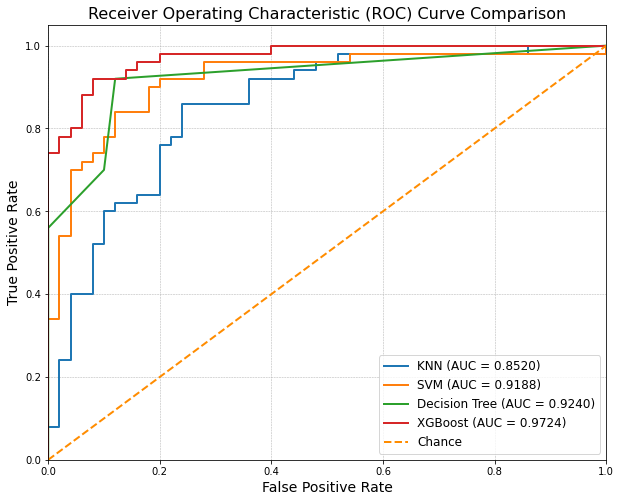

In [43]:
plt.figure(figsize=(10, 8))

# Plot ROC curve for KNN
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'KNN (AUC = {roc_auc_lr:.4f})')

# Plot ROC curve for SVM
plt.plot(fpr_svm, tpr_svm, lw=2, label=f'SVM (AUC = {roc_auc_svm:.4f})')

# Plot ROC curve for Logistic Regression
#plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')

# Plot ROC curve for Decision Tree
plt.plot(fpr_dect, tpr_dect, lw=2, label=f'Decision Tree (AUC = {roc_auc_dect:.4f})')

# Plot ROC curve for XGBoost
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance')

# Enhance plot aesthetics
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=12)

# Show the plot
plt.show()
